# 1.Libraries

In [ ]:
#!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0
#!pip uninstall transformers
#!pip install transformers==4.8.0

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 12.9 MB/s 
     |████████████████████████████████| 6.5 MB 30.4 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 31.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from google.colab import files

# specify GPU
device = torch.device("cuda")

# 2.Load Dataset

In [ ]:
#Por si se desean cargar los archivos desde google drive

from google.colab import drive
 
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#files.upload()

## 2.1 Dataset fake.

### The name of *fake* is updated in this notebook for *deceptive* to be a bit more formal.

In [ ]:
df=pd.read_csv('CellPhonesAccessoriesdeceptivetruthful_dataset.txt')

In [ ]:
df

,reviewText,deceptive
0,I originally ordered screen protectors in Dece...,0
1,I used this item for little over a month and t...,0
2,I wanted something to protect my phone from bo...,0
3,I had a local stereo shop install this item.\n...,0
4,"I've went through a few cases from Case Crown,...",0
...,...,...
656,"<|start|>,""I have been using this phone for a ...",1
657,Camera If you have not used a smartphone the i...,1
658,",""I have owned these for less than a week and ...",1
659,I like that the charger will charge all the de...,1


Here we divide the dataset in *Train,Validation and Test data*

In [ ]:
df=pd.read_csv(url)

df = df.sample(frac=1).reset_index(drop=True) #To suffle the data

train_text, temp_text,train_labels, temp_labels = train_test_split(df['reviewText'],df['deceptive'], random_state=42, train_size=0.7, stratify=df.deceptive)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=42, train_size=0.5, stratify= temp_labels)  
test_labels.value_counts(normalize=True)

0    0.76
1    0.24
Name: deceptive, dtype: float64

In [ ]:
df['reviewText']

0      This is a great product.  I almost crashed on ...
1      So far the best case I've used on any phone.\n...
2      <div id="video-block-R2N0B5T3BLYT6Z" class="a-...
3      Please do the math and see how long it will ta...
4      When charging the battery up to 100%\n But whe...
                             ...                        
656    <|start|>,"First of all, I would like to point...
657    <|start|>,"I just received this today and trie...
658    I adore this little company and hope that they...
659    This device seems to be working fairly well - ...
660                                 Other nice features:
Name: reviewText, Length: 661, dtype: object

Now we can see that the order of the rows have changed

In [ ]:
df

,reviewText,deceptive
0,This is a great product. I almost crashed on ...,0
1,So far the best case I've used on any phone.\n...,0
2,"<div id=""video-block-R2N0B5T3BLYT6Z"" class=""a-...",0
3,Please do the math and see how long it will ta...,1
4,When charging the battery up to 100%\n But whe...,0
...,...,...
656,"<|start|>,""First of all, I would like to point...",1
657,"<|start|>,""I just received this today and trie...",1
658,I adore this little company and hope that they...,1
659,This device seems to be working fairly well - ...,0


# 3.Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

# 4.Tokenization

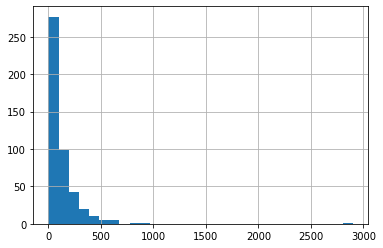

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 500

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_text

571    This case is super cute! Fits my iPhone perfec...
128    I purchased this item, because the case from P...
343    This is a great entry-level Android phone!  I ...
294    Review Update:\n\nOnly after I wrote my initia...
73     When I got my phone, I soon realized that beca...
                             ...                        
447    The phone recognizes the "clone" battery and c...
190    fits the s3 well, and the cutouts line up well...
280    Purchased this item as an external power sourc...
316    The case was much thicker than than I would ex...
604     - It does cancel some of the sluggish USB speeds
Name: reviewText, Length: 100, dtype: object

In [ ]:
len(test_text)

100

## Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


## Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


# 5.Model

## Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.2) ###
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)   #input dimension 
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)   #LogSoftmax inicial
      self.prob = nn.Softmax(dim=1)
      #self.sigmoid=nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs) #Full conected layer (Dense)

      x = self.relu(x)  #Relu activation

      x = self.dropout(x) #Dropout

      # output layer
      x = self.fc2(x)  #Full contected layer
      
      # apply softmax activation
      x1 = self.softmax(x)
      
      probs= self.prob(x)

      return x1, probs

In [ ]:
#device = torch.device("cpu")

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Find Class Weights

In [ ]:
###To know if a dataset is balanced /unbalanced

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y= train_labels)

print(class_wts)

[0.66189112 2.04424779]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

# Fine-Tune BERT

### TRAINING

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  total_pred_prob=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds, pred_prob = model(sent_id, mask)  ##

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    pred_prob=pred_prob.detach().cpu().numpy()
    
    # append the model predictions
    total_preds.append(preds)
    total_pred_prob.append(pred_prob)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds, total_pred_prob

### VALIDATION

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_pred_prob=[]

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds, pred_prob = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      #preds = preds.detach().cpu().numpy()

      #total_preds.append(preds)

      preds=preds.detach().cpu().numpy()
      pred_prob=pred_prob.detach().cpu().numpy()
    
      # append the model predictions
      total_preds.append(preds)
      total_pred_prob.append(pred_prob)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds, total_pred_prob

## Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ , pred_prob = train()
    
    #evaluate model
    valid_loss, _ , pred_prob = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/saved_weights1.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20

Evaluating...

Training Loss: 0.698
Validation Loss: 0.637

 Epoch 2 / 20

Evaluating...

Training Loss: 0.660
Validation Loss: 0.567

 Epoch 3 / 20

Evaluating...

Training Loss: 0.593
Validation Loss: 0.470

 Epoch 4 / 20

Evaluating...

Training Loss: 0.535
Validation Loss: 0.436

 Epoch 5 / 20

Evaluating...

Training Loss: 0.499
Validation Loss: 0.456

 Epoch 6 / 20

Evaluating...

Training Loss: 0.483
Validation Loss: 0.424

 Epoch 7 / 20

Evaluating...

Training Loss: 0.470
Validation Loss: 0.402

 Epoch 8 / 20

Evaluating...

Training Loss: 0.397
Validation Loss: 0.446

 Epoch 9 / 20

Evaluating...

Training Loss: 0.491
Validation Loss: 0.316

 Epoch 10 / 20

Evaluating...

Training Loss: 0.398
Validation Loss: 0.385

 Epoch 11 / 20

Evaluating...

Training Loss: 0.374
Validation Loss: 0.298

 Epoch 12 / 20

Evaluating...

Training Loss: 0.559
Validation Loss: 0.390

 Epoch 13 / 20

Evaluating...

Training Loss: 0.714
Validation Loss: 0.376

 Epoch 14 / 20

Eval

## Load Saved Model

In [ ]:
#load weights of best model
path = '/content/drive/MyDrive/Colab Notebooks/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# 6. Get Predictions for Test Data

## Predictions

In [ ]:
with torch.no_grad():
  preds, pred_prob = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  pred_prob = pred_prob.detach().cpu().numpy()

## Our model is going to classify the reviews in the test seet as True or Fake.

## We define the terms we see in the results.
## We name the 0 (true) as negative and 1 (fake) as positive, as we are identifying fake reviews.

### We have different kinds of results:
### -Reviews true that are really true (True negative, TN)
### -Reviews fake that are really fake ( True positive, TP)
### -Reviews fake that are really true (False positive, FP)
### -Reviews true that are really fake. (False negative, FN)

## According these results we can measure different metrics

## Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations
### Accuracy = TP+TN/TP+FP+FN+TN

## Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
### Precision = TP/TP+FP

## Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class 
### Recall = TP/TP+FN

## F1 score - F1 Score is the weighted average of Precision and Recall.
### F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        76
           1       0.73      0.92      0.81        24

    accuracy                           0.90       100
   macro avg       0.85      0.91      0.87       100
weighted avg       0.91      0.90      0.90       100



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,68,8
1,2,22


## We can see the distribution of classifications with the Confussion matrix
## The model identifies: 1) 68 true that are really true (True negative, TN); 2) 22 fake that are really fake ( True positive, TP); 3) 8 as fake that is really true (False positive, FP); and 4) 2 as true that are really fake. (False negative, FN)

## We can also see the probability predicted by the model for each classification.
## Threshold: Probability that the prediction is in one of the two options: (Left 0: True, Right 1: Fake)

In [ ]:
pred_prob

array([[0.88662684, 0.11337318],
       [0.9357682 , 0.06423175],
       [0.58312714, 0.4168729 ],
       [0.7693554 , 0.23064466],
       [0.9727278 , 0.02727215],
       [0.02870584, 0.9712941 ],
       [0.8829566 , 0.11704339],
       [0.2355792 , 0.7644208 ],
       [0.01471928, 0.9852807 ],
       [0.13733631, 0.8626637 ],
       [0.9617571 , 0.03824291],
       [0.5561303 , 0.4438697 ],
       [0.5613225 , 0.43867746],
       [0.04429593, 0.95570403],
       [0.01810705, 0.98189294],
       [0.689463  , 0.31053704],
       [0.9402163 , 0.05978369],
       [0.7347708 , 0.26522925],
       [0.9555195 , 0.04448054],
       [0.05140695, 0.9485931 ],
       [0.89833134, 0.10166863],
       [0.8191772 , 0.1808228 ],
       [0.9353645 , 0.0646355 ],
       [0.96109027, 0.03890973],
       [0.6403086 , 0.35969138],
       [0.9015703 , 0.09842967],
       [0.18207407, 0.81792593],
       [0.94207937, 0.05792065],
       [0.94960994, 0.05039008],
       [0.9041356 , 0.09586444],
       [0.

# Now we tune our predictions increasing the threshold to classify reviews. The default is in 50%, we want to increase the likelihood to make correct classifications. 

## The cost of this adjustment is to get less fake reviews, as the ones with lower probability wont be classified as fake

In [ ]:
threshold= 0.8 #Inicial 0.8
probability= pred_prob[:,1] #We keep only second column: probability of fake.

total_preds=[]
for i in range(len(probability)):
  if probability[i]>threshold:
    help=1
  if probability[i]<threshold:  
    help=0
  total_preds.append(help)

print(total_preds)

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
print(classification_report(test_y, total_preds))  #Obtenemos una precision de 1 en las reviews que son utiles

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        76
           1       0.94      0.71      0.81        24

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100



## The model identifies: 1)75 true that are really true, 2) 17 fake that are really fake 

## 3) 1 as fake that is really true and 4) 7 as true that are really fake.

### changing the thresshold our model works different, identifying less fake reviews but with more accuracy, as the model only classify when the probability is aboce 80%, rather than before where the threshold was 50%

In [ ]:
# confusion matrix
total_preds=np.array(total_preds) 
pd.crosstab(test_y, total_preds)


col_0,0,1
row_0,,
0,75,1
1,7,17


# We can do a little research to analyze the fake reviews to understand their main keywords

In [ ]:
len(test_y)

100

In [ ]:
np.where(total_preds==1)

(array([ 5,  8,  9, 13, 14, 19, 26, 32, 44, 45, 52, 61, 67, 68, 74, 84, 85,
        99]),)

In [ ]:
index_thrustworthy=np.where(total_preds==1)
index_thrustworthy

(array([ 5,  8,  9, 13, 14, 19, 26, 32, 44, 45, 52, 61, 67, 68, 74, 84, 85,
        99]),)

In [ ]:
test_text.iloc[index_thrustworthy]

110    ,"Can't beat the quality for all of the featur...
157    |<|start|>,"I had previously a Galaxy S case t...
362    <|start|>,"The ID Case fits the Samsung Captiv...
278    <|start|>,"The phone is very good is a very go...
464                                                    6
377    ,"I got the white case and it fits great.  It'...
613    I purchased a&nbsp;<a data-hook="product-link-...
211    <|start|>,"I did a lot of research before fina...
170    The clip has a good fit, and the phone feels q...
539    ,"I just received this case and holder today. ...
295    <|start|>,"I was looking for a 5V battery for ...
250    ,"I've been trading off between Symbian and An...
529    Screen is Sharp and Magnetic ""PierNo"""" patt...
98     ,"I was a bit skeptical of this headset, but i...
23     <|start|>,"I read many of the reviews for this...
198    <|start|>,"I was skeptical of buying this cabl...
486    Note: I didn't know that intuit if it was in t...
604     - It does cancel some o

### Here I identify reviews in chunks of 100 reviews, for computational limitations.

In [ ]:
Array_Thrustworthy_0_100=[11, 14, 16, 37, 57, 69, 77, 81, 98]
Array_Thrustworthy_100_200=[104, 140, 147, 157, 168, 177, 178, 184, 190, 193, 194, 196, 197]
Array_Thrustworthy_200_300=[206, 215, 222, 230, 232, 235, 236, 240, 245, 248, 253, 265, 291,292]
Array_Thrustworthy_300_400=[307, 331, 332, 340, 341, 345, 351, 362, 364, 376, 382, 390]
Array_Thrustworthy_400_500=[403, 412, 414, 441, 478, 480, 481, 498]
Array_Thrustworthy_500_600=[501, 503, 511, 513, 530, 559, 568, 582, 586, 590, 595]

In [ ]:
Array_Index_Complete=[11, 14, 16, 37, 57, 69, 77, 81, 98,104, 140, 147, 157, 168, 177, 178, 184, 190, 193, 194, 196, 197,206, 215, 222, 230, 232, 235, 236, 240, 245, 248, 253, 265, 291,292,307, 331, 332, 340, 341, 345, 351, 362, 364, 376, 382, 390,403, 412, 414, 441, 478, 480, 481, 498,501, 503, 511, 513, 530, 559, 568, 582, 586, 590, 595]

In [ ]:
print(df.iloc[Array_Index_Complete]['reviewText'])

11     Bows out in the back, creating a gap that allows in whatever is in your pocket which then scratches the back of the phone, defeating the purpose of the case.\n\nWill try reaching out to the seller.  If I get a replacement (at no cost or hassle) that fits correctly I will promptly update this review.\n\nI like the case in concept, there is a small protrusion on the top and bottom which gives an additional small measure of protection.  At first I wasn't sure about that bit, but I've decided I like it.\nThere's also enough coverage on the front to keep the screen off of a flat surface when placed screen down.
14     At first I wasn't to sure about a Motorola droid phone as I owned a Samsung; but I have to say that I'm more than happy with this cell phone; after upgrading to ICS the menus and the applications are a lot faster; the battery duration is very good and I'm very suprised by the resolution of the display; It is a very cheap phone for the quality it has.                    

In [ ]:
df.iloc[Array_Index_Complete]['reviewText']

11     Bows out in the back, creating a gap that allows in whatever is in your pocket which then scratches the back of the phone, defeating the purpose of the case.\n\nWill try reaching out to the seller.  If I get a replacement (at no cost or hassle) that fits correctly I will promptly update this review.\n\nI like the case in concept, there is a small protrusion on the top and bottom which gives an additional small measure of protection.  At first I wasn't sure about that bit, but I've decided I like it.\nThere's also enough coverage on the front to keep the screen off of a flat surface when placed screen down.
14     At first I wasn't to sure about a Motorola droid phone as I owned a Samsung; but I have to say that I'm more than happy with this cell phone; after upgrading to ICS the menus and the applications are a lot faster; the battery duration is very good and I'm very suprised by the resolution of the display; It is a very cheap phone for the quality it has.                    

# Now we install KEYBERT, a model based on BERT to analyze a text and report the main keywords

In [ ]:
pip install keybert

     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 224 kB 28.1 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 25.0 MB/s 
  Created wheel for keybert: filename=keybert-0.5.0-py3-none-any.whl size=20491 sha256=5e497f2a866f39fbd34d2b1add39b4224eb055b156ed440a1d590427d030c36e
  Stored in directory: /root/.cache/pip/wheels/99/1f/3f/590d2997adbb2d0e1f82e8ee05d42d6910e92c3ed283015ff8
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=8b38e416860a5cedcdaa95c6df1171cce6ee90a0e6bf24ee93777fa7a0221221
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built keybert sentence-transformers


In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT(model='all-mpnet-base-v2')

In [ ]:
doc="""
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """
keywords = kw_model.extract_keywords(doc)
print(keywords)

[('learning', 0.4818), ('supervised', 0.4577), ('algorithm', 0.3128), ('labeled', 0.3111), ('inductive', 0.298)]


In [ ]:
doc= df.iloc[Array_Index_Complete]['reviewText'].sum()
doc

'Bows out in the back, creating a gap that allows in whatever is in your pocket which then scratches the back of the phone, defeating the purpose of the case.\n\nWill try reaching out to the seller.  If I get a replacement (at no cost or hassle) that fits correctly I will promptly update this review.\n\nI like the case in concept, there is a small protrusion on the top and bottom which gives an additional small measure of protection.  At first I wasn\'t sure about that bit, but I\'ve decided I like it.\nThere\'s also enough coverage on the front to keep the screen off of a flat surface when placed screen down.At first I wasn\'t to sure about a Motorola droid phone as I owned a Samsung; but I have to say that I\'m more than happy with this cell phone; after upgrading to ICS the menus and the applications are a lot faster; the battery duration is very good and I\'m very suprised by the resolution of the display; It is a very cheap phone for the quality it has.My biggest complaint about m

In [ ]:
keywords = kw_model.extract_keywords(doc)
print(keywords)

[('otterbox', 0.4355), ('motorola', 0.3825), ('razr', 0.3619), ('droid4', 0.3537), ('mophie', 0.3401)]


In [ ]:
keywords=kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=20, use_mmr=True, diversity=0.7)
keywords
#aux=[item[0] for item in keywords]
#aux2=[item[1] for item in keywords]
#KeyWords = pd.DataFrame(aux, columns=['Barcelona'])
#KeyWords['Barcelona_value'] = aux2

[('otterbox', 0.4355),
 ('longer', 0.0557),
 ('cuz', 0.0798),
 ('hated', 0.0437),
 ('cm_cr_arp_d_rvw_txt', 0.0684),
 ('does', 0.0205),
 ('coming', 0.0129),
 ('responsiveness', 0.1435),
 ('unless', 0.0211),
 ('slide', 0.0889),
 ('combining', 0.0886),
 ('instrumental', 0.0211),
 ('allow', 0.0522),
 ('2006', 0.0641),
 ('buy', 0.0342),
 ('abouti', 0.1043),
 ('sqeege', 0.0839),
 ('unsupported', 0.0625),
 ('calls', 0.1766),
 ('tiniest', 0.0598)]

In [ ]:
[item[0] for item in keywords]

['otterbox',
 'longer',
 'cuz',
 'hated',
 'cm_cr_arp_d_rvw_txt',
 'does',
 'coming',
 'responsiveness',
 'unless',
 'slide',
 'combining',
 'instrumental',
 'allow',
 '2006',
 'buy',
 'abouti',
 'sqeege',
 'unsupported',
 'calls',
 'tiniest']